In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anomaly-detection/Submission.csv
/kaggle/input/anomaly-detection/train.csv
/kaggle/input/anomaly-detection/test.csv


In [2]:
import datetime
pd.set_option('display.max_columns', None)
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report,roc_auc_score
import xgboost
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [3]:
df=pd.read_csv(r"/kaggle/input/anomaly-detection/train.csv")

In [4]:
df.head()

,timestamp,value,is_anomaly,predicted
0,1425008573,42,False,44.072500
1,1425008873,41,False,50.709390
2,1425009173,41,False,81.405120
3,1425009473,61,False,39.950367
4,1425009773,44,False,35.350160


In [5]:
df.describe()

,timestamp,value,predicted
count,1.583000e+04,15830.000000,15830.000000
mean,1.427383e+09,85.572205,71.870715
std,1.370962e+06,321.760918,92.450520
min,1.425009e+09,0.000000,-281.389070
25%,1.426196e+09,29.000000,32.919171
50%,1.427383e+09,47.000000,49.771124
75%,1.428570e+09,76.000000,75.948052
max,1.429757e+09,13479.000000,2716.127200


In [6]:
df.is_anomaly.value_counts()

is_anomaly
False    15054
True       776
Name: count, dtype: int64

In [7]:
df['timestamp_new']=df['timestamp'].apply(lambda x: datetime.datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
df['timestamp_new']=df['timestamp_new'].apply(lambda x: datetime.datetime.fromisoformat(x))

In [8]:
df['Date']=df['timestamp_new'].dt.date
df['month']=df['timestamp_new'].dt.month
df['year']=df['timestamp_new'].dt.year
df['hour']=df['timestamp_new'].dt.hour
df['minute']=df['timestamp_new'].dt.minute


In [9]:
df.pivot_table(index='hour', columns=['is_anomaly','month'] ,aggfunc='size')

is_anomaly False               True             
month          2      3      4     2     3     4
hour                                            
0           12.0  357.0  261.0   NaN  15.0  15.0
1           12.0  355.0  262.0   NaN  17.0  14.0
2           10.0  350.0  263.0   2.0  22.0  11.0
3           11.0  345.0  236.0   5.0  27.0  28.0
4           22.0  359.0  251.0   2.0  13.0  13.0
5           19.0  362.0  248.0   5.0  10.0  16.0
6           24.0  358.0  258.0   NaN  14.0   6.0
7           24.0  366.0  258.0   NaN   6.0   6.0
8           24.0  347.0  257.0   NaN  25.0   7.0
9           24.0  366.0  253.0   NaN   6.0  11.0
10          23.0  367.0  261.0   1.0   5.0   3.0
11          23.0  358.0  258.0   1.0  14.0   6.0
12          24.0  355.0  257.0   NaN  17.0   7.0
13          23.0  355.0  259.0   1.0  17.0   5.0
14          22.0  341.0  241.0   2.0  31.0  23.0
15          22.0  353.0  249.0   2.0  19.0  15.0
16          21.0  358.0  242.0   3.0  14.0  22.0
17          19.0  345.0  251.0   5.0  27.0  13.0
18          24.0  353.0  240.0   NaN  19.0  24.0
19          23.0  353.0  248.0   1.0  19.0  16.0
20          23.0  356.0  240.0   1.0  16.0  24.0
21          23.0  342.0  245.0   1.0  30.0  19.0
22          24.0  358.0  249.0   NaN  14.0  15.0
23          23.0  363.0  246.0   1.0   9.0  18.0

In [10]:
df.pivot_table(index='is_anomaly', columns=['month'] ,aggfunc='size')

month,2,3,4
is_anomaly,,,
False,499,8522,6033
True,33,406,337


In [11]:
df.groupby(['month'])['is_anomaly'].agg({'count'})

,count
month,
2,532
3,8928
4,6370


In [12]:
### for the column value

In [13]:
df.pivot_table(index='is_anomaly',values=['value'] ,columns=['month'] ,aggfunc='sum')

value                
month           2       3       4
is_anomaly                       
False       24375  515569  391011
True         4523  225294  193836

In [14]:
df.pivot_table(index='is_anomaly',values=['predicted'] ,columns=['month'] ,aggfunc='sum')

predicted                             
month                  2             3              4
is_anomaly                                           
False       27331.276558  618479.67178  417261.002566
True         2108.028185   33829.11231   38704.329048

<Axes: >

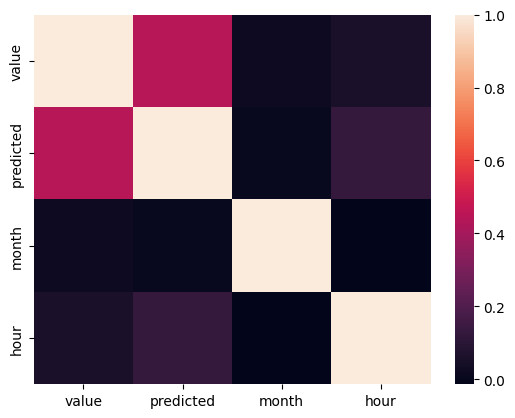

In [15]:
import seaborn as sns


sns.heatmap(df[['value','predicted','month','hour']].corr())

In [16]:
df[['value','predicted','month','hour','is_anomaly','minute']].corr()

,value,predicted,month,hour,is_anomaly,minute
value,1.000000,0.445180,0.020209,0.053446,0.324859,-0.014410
predicted,0.445180,1.000000,0.008664,0.127201,0.059719,-0.014400
month,0.020209,0.008664,1.000000,-0.013950,0.009517,-0.000943
hour,0.053446,0.127201,-0.013950,1.000000,0.019604,-0.000108
is_anomaly,0.324859,0.059719,0.009517,0.019604,1.000000,0.001840
minute,-0.014410,-0.014400,-0.000943,-0.000108,0.001840,1.000000


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

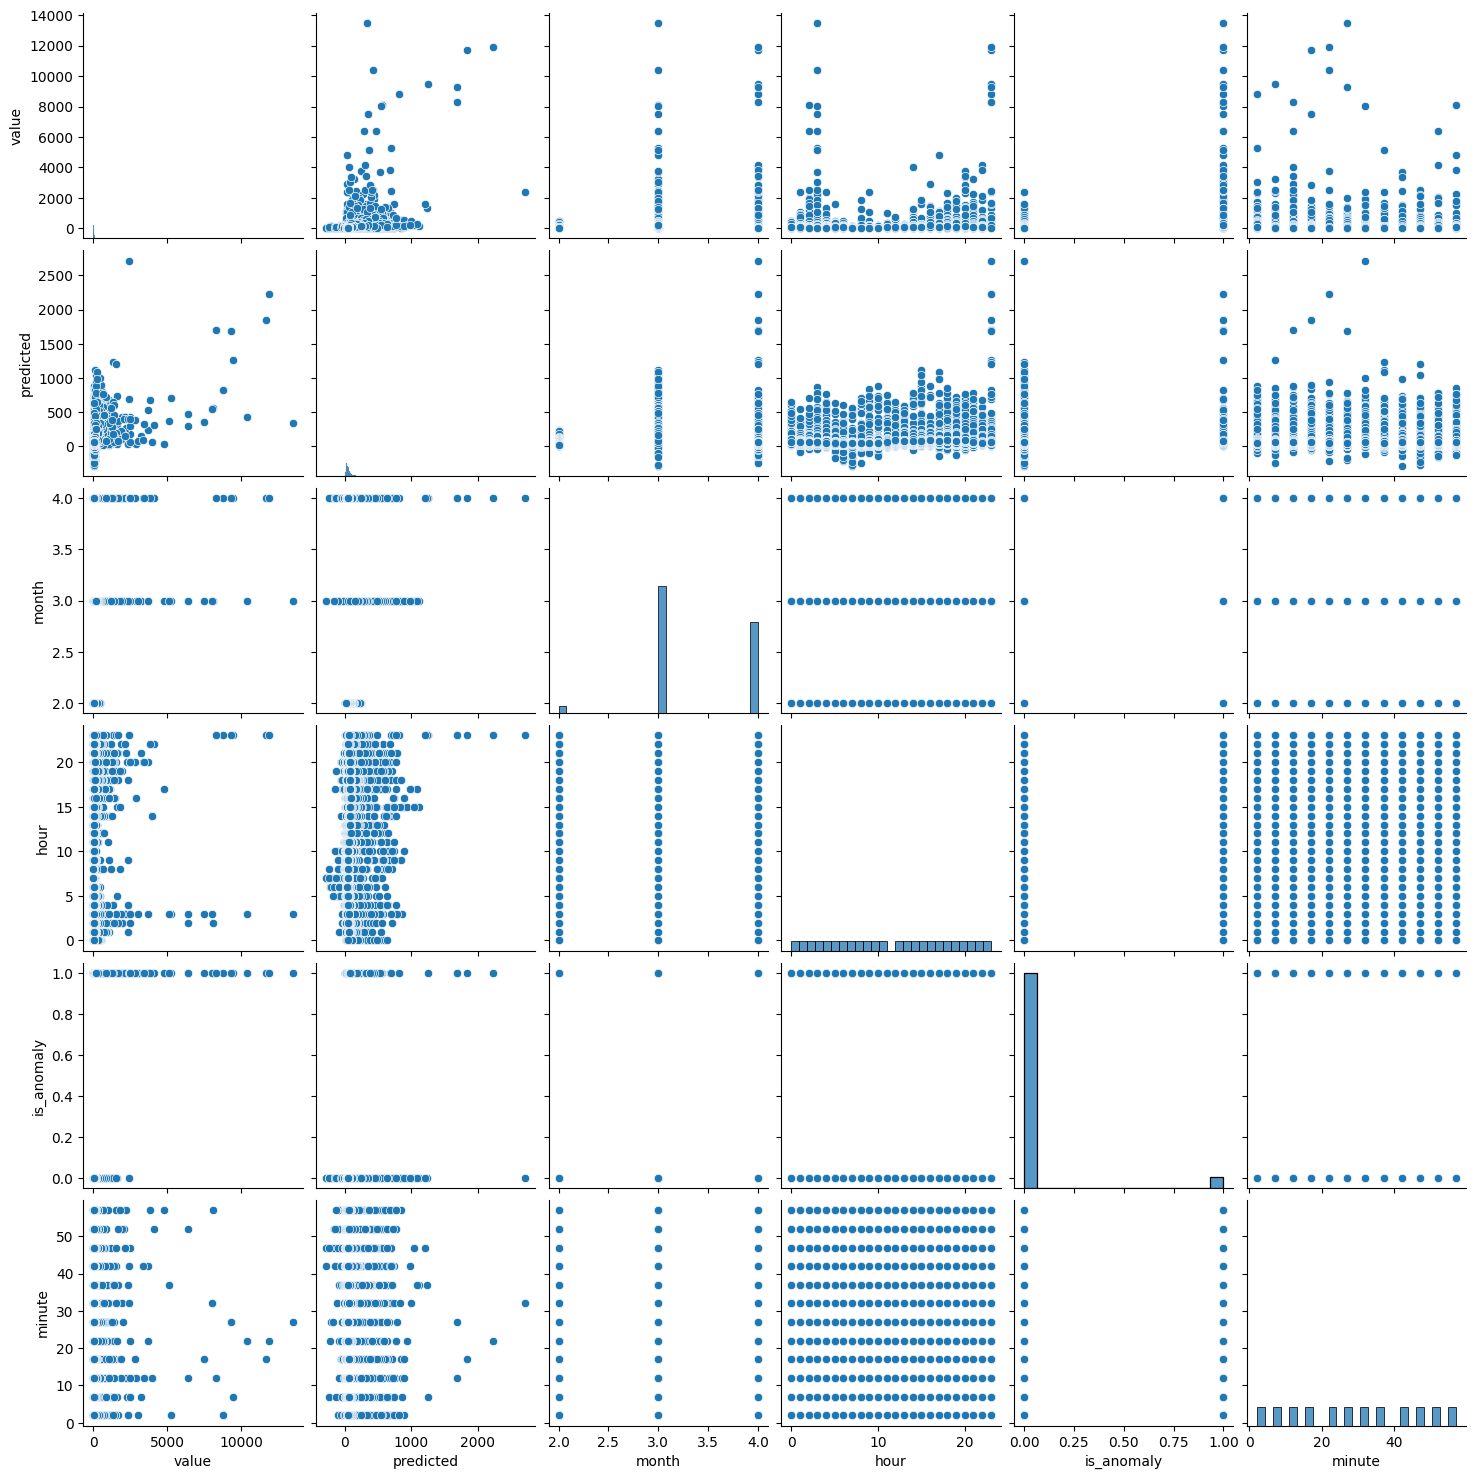

In [17]:
sns.pairplot(df[['value','predicted','month','hour','is_anomaly','minute']])

/tmp/ipykernel_18/149393957.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pow(df['predicted'],1/10), bins=10)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='predicted', ylabel='Density'>

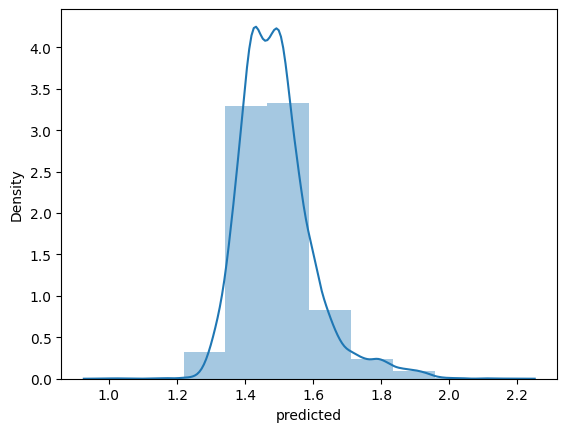

In [18]:
import math
sns.distplot(pow(df['predicted'],1/10), bins=10)

/tmp/ipykernel_18/799712854.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pow(df['value'],1/6),bins=10)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='value', ylabel='Density'>

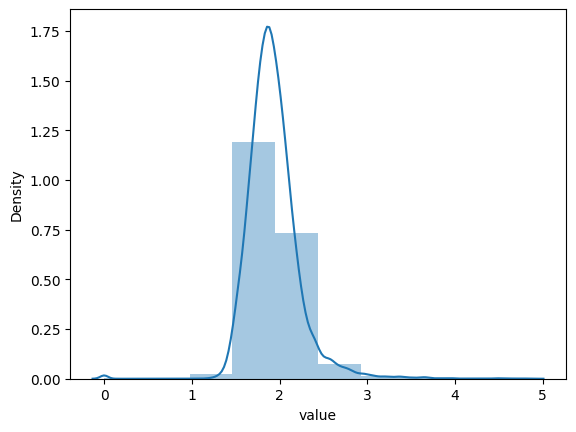

In [19]:
sns.distplot(pow(df['value'],1/6),bins=10)

In [20]:
np.percentile(df['value'],99.99)

11779.505499999745

In [21]:
df['value'].describe()

count    15830.000000
mean        85.572205
std        321.760918
min          0.000000
25%         29.000000
50%         47.000000
75%         76.000000
max      13479.000000
Name: value, dtype: float64

In [22]:
df_final=pd.DataFrame()
df_final['trans_pred']=pow(df['value'],1/10)
df_final['trans_value']=pow(df['value'],1/6)
df_final['hour']=df['hour']
df_final['is_anmly']=df['is_anomaly']
df_final['month']=df['month']

In [23]:
df_final['is_anmly']=df_final['is_anmly'].apply(lambda x: 0 if x==False else 1)


In [24]:
df_final

,trans_pred,trans_value,hour,is_anmly,month
0,1.453198,1.864411,3,0,2
1,1.449701,1.856938,3,0,2
2,1.449701,1.856938,3,0,2
3,1.508457,1.984061,3,0,2
4,1.459974,1.878922,4,0,2
...,...,...,...,...,...
15825,1.459974,1.878922,2,0,4
15826,1.463259,1.885973,2,0,4
15827,1.472733,1.906369,2,0,4
15828,1.385152,1.721190,2,0,4


In [25]:
# x_train, x_test, y_train, y_test=train_test_split(df_final[['trans_pred','trans_value','hour','month']],df_final['is_anmly'], test_size=0.2, random_state=1)
x_train, x_test, y_train, y_test=train_test_split(df[['predicted','value','hour','month']],df['is_anomaly'], test_size=0.2, random_state=1)

In [26]:
x_train_sub,x_val,y_train_sub,y_val=train_test_split(x_train, y_train, test_size=0.2, random_state=1)

In [27]:
def optimize(trial):
    params={
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'max_depth': trial.suggest_int('max_depth',2,10),
        'eta': trial.suggest_loguniform('eta',0.001,0.5),
        'gamma': trial.suggest_uniform('gamma',0.01,1),
        'lambda': trial.suggest_uniform('lambda',0.1,1),
        'min_child_weight': trial.suggest_loguniform('min_child_weight',0.1,1),
        'subsample': trial.suggest_uniform('subsample',0.1,1),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree',0.1,1),
        'scale_pos_weight': trial.suggest_int('scale_pos_weight',1,5)
    }
    clf_opt=XGBClassifier(**params,random_state=1)
    
    clf_opt.fit(x_train_sub,y_train_sub)
    pred_opt=clf_opt.predict(x_val)
    auc_score = roc_auc_score(y_val, pred_opt)
    return auc_score

    

In [28]:
import optuna
study=optuna.create_study(direction='maximize')
study.optimize(optimize,n_trials=100)

[I 2024-05-11 12:30:49,373] A new study created in memory with name: no-name-18a698a8-0369-4d96-9842-8259cd8d968a
/tmp/ipykernel_18/3414446748.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta',0.001,0.5),
/tmp/ipykernel_18/3414446748.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'gamma': trial.suggest_uniform('gamma',0.01,1),
/tmp/ipykernel_18/3414446748.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'lambda': trial.suggest_uniform('lambda',0.1,1),
/tmp/ipykernel_18/3414446748.py:8: FutureWarning:

In [29]:
best_param=study.best_params

In [30]:
best_param

{'n_estimators': 83,
 'max_depth': 5,
 'eta': 0.09948224281334746,
 'gamma': 0.4224961410619056,
 'lambda': 0.878793476883839,
 'min_child_weight': 0.999568540234695,
 'subsample': 0.7852212770273082,
 'colsample_bytree': 0.927851108277257,
 'scale_pos_weight': 5}

In [31]:
best_model = XGBClassifier(**best_param,random_state=1)
best_model.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.927851108277257, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.09948224281334746, eval_metric=None, feature_types=None,
              gamma=0.4224961410619056, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.878793476883839,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=0.999568540234695, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=83,
              n_jobs=None, ...)

In [32]:
predict=best_model.predict(x_test)

In [33]:
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

       False       0.99      0.98      0.98      3025
        True       0.62      0.77      0.69       141

    accuracy                           0.97      3166
   macro avg       0.80      0.88      0.84      3166
weighted avg       0.97      0.97      0.97      3166



In [34]:
test_df=pd.read_csv(r"/kaggle/input/anomaly-detection/test.csv")

In [35]:
test_df

,timestamp,value,predicted
0,1396332000,20.00000,20.000000
1,1396332300,20.00000,20.000000
2,1396332600,20.00000,20.000000
3,1396332900,20.00000,20.000000
4,1396333200,20.00000,20.000000
...,...,...,...
3955,1397518500,20.00384,19.836240
3956,1397518800,20.00384,19.207998
3957,1397519100,20.00384,20.103437
3958,1397519400,20.00384,19.346764


In [36]:
test_df['timestamp_new']=test_df['timestamp'].apply(lambda x: datetime.datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
test_df['timestamp_new']=test_df['timestamp_new'].apply(lambda x: datetime.datetime.fromisoformat(x))

In [37]:
test_df['Date']=test_df['timestamp_new'].dt.date
test_df['month']=test_df['timestamp_new'].dt.month
test_df['year']=test_df['timestamp_new'].dt.year
test_df['hour']=test_df['timestamp_new'].dt.hour
test_df['minute']=test_df['timestamp_new'].dt.minute

In [38]:
test_pred=best_model.predict(test_df[['predicted','value','hour','month']])

In [39]:
sub_df=pd.DataFrame(columns=["timestamp","is_anomaly"])

In [40]:
sub_df['timestamp']=test_df['timestamp']

In [41]:
sub_df['is_anomaly']=pd.Series(test_pred)

In [42]:
sub_df['is_anomaly'].value_counts()

is_anomaly
0    3935
1      25
Name: count, dtype: int64

In [43]:
sub_df['is_anomaly']=sub_df['is_anomaly'].apply(lambda x: 1 if x==True else False)

In [44]:
sub_df

,timestamp,is_anomaly
0,1396332000,False
1,1396332300,False
2,1396332600,False
3,1396332900,False
4,1396333200,False
...,...,...
3955,1397518500,False
3956,1397518800,False
3957,1397519100,False
3958,1397519400,False


In [45]:
sub_df.to_csv('submission.csv', index=False)